{'Rotation': 0.0, 'Particles': 1000}


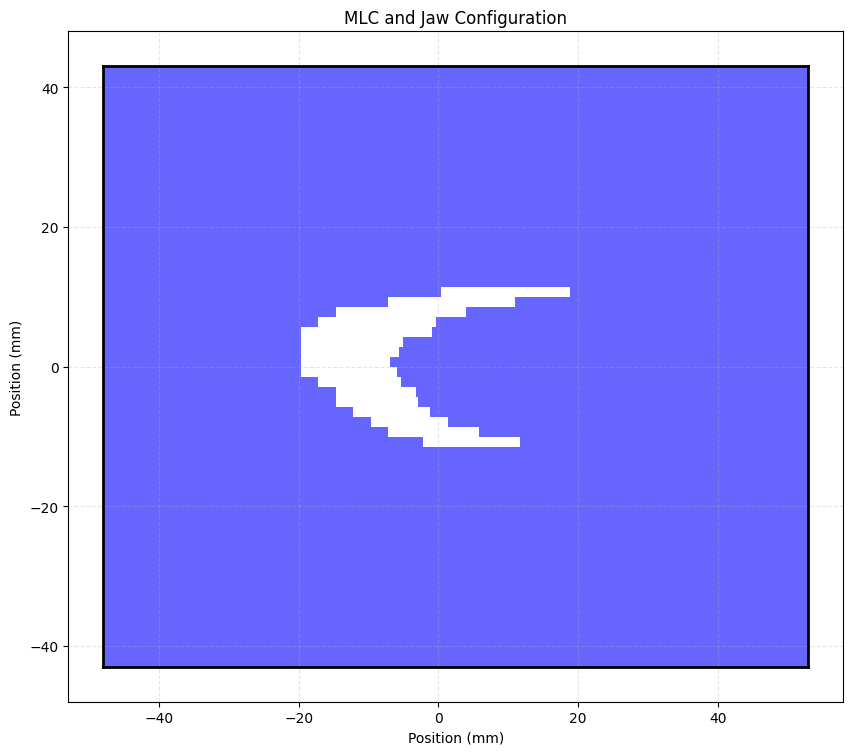

In [1]:
import numpy as np
import matplotlib.pyplot as plt

file = "1. prostate_imrt_beam0_cp0.dat"

def parse_mlc_data():
    with open(file) as fp:
      data = fp.read()
    lines = data.strip().split('\n')
    
    # read data from comments
    comments = [line for line in lines if line.startswith('#')]
    comment_params = {}
    for comment in comments:
        key = comment.removeprefix("# ").rstrip("0123456789. :")
        value = comment.removeprefix('# ').split(" ", 1)[1]
        if '.' in value:
            try:
                value = float(value)
            except ValueError:
                continue
        else:
            try:
                value = int(value)
            except ValueError:
                continue
        comment_params[key] = value
    
    # remove comments, no longer needed
    lines = [line for line in lines if not line.startswith("#")]
    
    # Parse jaws data
    jaws = map(float, lines[0].split(','))
    
    # Parse MLC positions
    mlc_positions = []
    for line in lines[1:]:
        if ',' in line:
            left, right = map(float, line.split(','))
            mlc_positions.append((left, right))
    
    return jaws, np.array(mlc_positions), comment_params

def plot_mlc_configuration():
    # Parse data
    (X1, X2, Y1, Y2), mlc_positions, comment_params = parse_mlc_data()
    print(comment_params)
    
    # Create figure
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    
    # Calculate leaf heights
    n_leaves = len(mlc_positions)
    leaf_heights = np.linspace(Y1, Y2, n_leaves + 1)
    leaf_height = (Y2 - Y1) / n_leaves # width of rectangles
    
    # Plot each MLC leaf pair
    # data is arranged bottom-up
    for i, (left, right) in enumerate(mlc_positions):
        y_pos = leaf_heights[i]

        # plot rectangles

        # (X1, y_pos + leaf_height)-----(left, ypos + leaf_height)
        # |                                       |
        # (X1, y_pos)-------------------(left, y_pos)
        plt.fill([X1, left, left, X1],
                [y_pos, y_pos, y_pos + leaf_height, y_pos + leaf_height],
                'blue', alpha=0.6)
        
        # (right, y_pos + leaf_height)-----(X2, ypos + leaf_height)
        # |                                       |
        # (right, y_pos)-------------------(X2, y_pos)
        plt.fill([right, X2, X2, right],
                [y_pos, y_pos, y_pos + leaf_height, y_pos + leaf_height],
                'blue', alpha=0.6)
    
    # Plot jaw boundaries
    plt.plot([X1, X1], [Y1, Y2], 'k-', linewidth=2)  # Left jaw
    plt.plot([X2, X2], [Y1, Y2], 'k-', linewidth=2)  # Right jaw
    plt.plot([X1, X2], [Y1, Y1], 'k-', linewidth=2)  # Bottom jaw
    plt.plot([X1, X2], [Y2, Y2], 'k-', linewidth=2)  # Top jaw
    
    # Set plot properties
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.xlabel('Position (mm)')
    plt.ylabel('Position (mm)')
    plt.title('MLC and Jaw Configuration')
    
    # Set equal aspect ratio and limits
    ax.set_aspect('equal')
    plt.xlim(X1 - 5, X2 + 5)
    plt.ylim(Y1 - 5, Y2 + 5)
    
    return plt.gcf()

# Create and display the plot
fig = plot_mlc_configuration()
plt.show()

    Cell IdX  Cell IdY  Cell IdZ  X [mm]  Y [mm]  Z [mm]      Dose  \
18         0         0         0     -18     -18       6  0.000097   
25         0         0         1     -18     -18      18  0.000201   
31         0         1         0     -18      -6       6  0.002524   
0          0         1         1     -18      -6      18  0.003416   
17         0         2         0     -18       6       6  0.005445   
14         0         2         1     -18       6      18  0.006825   
23         0         3         0     -18      18       6  0.000427   
30         0         3         1     -18      18      18  0.000737   
10         1         0         0      -6     -18       6  0.003053   
2          1         0         1      -6     -18      18  0.003953   
7          1         1         0      -6      -6       6  0.005773   
24         1         1         1      -6      -6      18  0.006948   
29         1         2         0      -6       6       6  0.005624   
11         1        

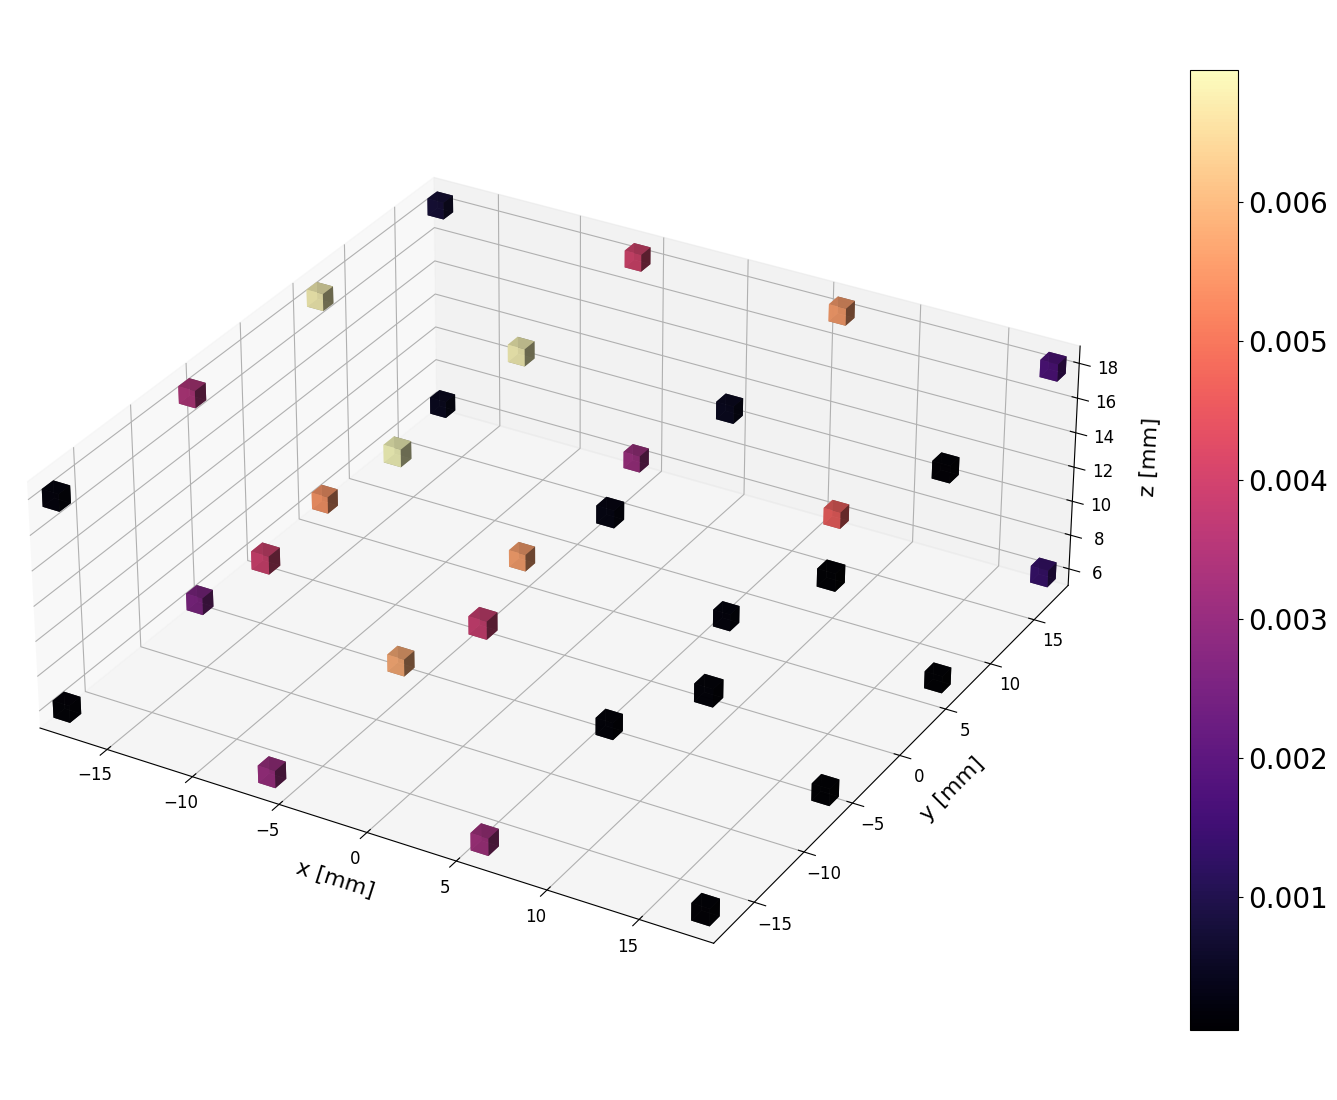

In [2]:
import pandas as pd
import polars as pl
import pyarrow as pa
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm

phantom_counts_cmap = cm.magma

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

counter=0

def add_voxel(ax, x_center, y_center, z_center, voxel_side_len, dose, min, max):
  x = [x_center - voxel_side_len / 2, x_center + voxel_side_len / 2]
  y = [y_center - voxel_side_len / 2, y_center + voxel_side_len / 2]
  z = [z_center - voxel_side_len / 2, z_center + voxel_side_len / 2]
  xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')

  global counter
  print(f"adding {counter} voxel...")
  counter+=1
  
  # phantom_counts_norm = colors.LogNorm(vmin=min, vmax=max)
  phantom_counts_norm = colors.Normalize(vmin=min, vmax=max)
  pc_normalized = phantom_counts_norm(dose)
  pc_colored = np.empty((*pc_normalized.shape, 4))
  with np.nditer(pc_normalized, flags=['multi_index']) as it:
    for el in it:
      pc_colored[it.multi_index] = phantom_counts_cmap(el, alpha=(0.9))
  ax.voxels(xx, yy, zz, np.ones((1,1,1), dtype=bool), facecolors=pc_colored, edgecolor=None)


if __name__ == "__main__":
  filename = "cp-0_d3ddetector_cell.csv"
  raw_df = pd.read_csv(filename)

  sorted_df = raw_df.sort_values(by=['X [mm]', 'Y [mm]', 'Z [mm]'])
  voxel_side_len = 0.985
  observable = "Dose"

  fig = plt.figure(figsize=(16, 12))
  ax = fig.add_subplot(111, projection='3d')
  
  df = sorted_df
  print(df)

  dose_max = df[observable].max()
  dose_min = df[df[observable]>0][observable].min()
  
  for _, row in df.iterrows():
      if row[observable] == 0:
          print(f"skipping row {row}")
          continue
      x_center = row['X [mm]']
      y_center = row['Y [mm]']
      z_center = row['Z [mm]']

      dose = row[observable]
      add_voxel(ax, x_center, y_center, z_center, voxel_side_len, dose, dose_min, dose_max)

  # Ustawienie limitów osi
  x_min, x_max = df['X [mm]'].min() - voxel_side_len, df['X [mm]'].max() + voxel_side_len
  y_min, y_max = df['Y [mm]'].min() - voxel_side_len, df['Y [mm]'].max() + voxel_side_len
  z_min, z_max = df['Z [mm]'].min() - voxel_side_len, df['Z [mm]'].max() + voxel_side_len

  ax.set_xlim([x_min, x_max])
  ax.set_ylim([y_min, y_max])
  ax.set_zlim([z_min, z_max])

  x_scale = x_max - x_min
  y_scale = y_max - y_min
  z_scale = z_max - z_min
  ax.set_box_aspect([1.2*x_scale, 1.2*y_scale, 1.2*z_scale])
  ax.set_xlabel("x [mm]", fontsize=16,labelpad=10)
  ax.set_ylabel("y [mm]", fontsize=16,labelpad=10)
  ax.set_zlabel("z [mm]", fontsize=16,labelpad=10)
  ax.tick_params(labelsize=12)
  plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
  scalar_mappable = cm.ScalarMappable(norm=colors.Normalize(vmin=dose_min, vmax=dose_max), cmap=phantom_counts_cmap)
  colorbar_axes = fig.add_axes([0.9, 0.1, 0.03, 0.8])  # Adjust the position as needed
  cbar = fig.colorbar(scalar_mappable, cax=colorbar_axes, shrink=1.0, fraction=0.1, pad=0)
  cbar.ax.tick_params(labelsize=20)
  plt.show()


voxel_no_per_cell: 10
iterating over input...
filling 64x64x64 space...
full x space: [-31.75 -31.25 -30.75 -30.25 -29.75 -29.25 -28.75 -28.25 -27.75 -27.25
 -26.75 -26.25 -25.75 -25.25 -24.75 -24.25 -23.75 -23.25 -22.75 -22.25
 -21.75 -21.25 -20.75 -20.25 -19.75 -19.25 -18.75 -18.25 -17.75 -17.25
 -16.75 -16.25 -15.75 -15.25 -14.75 -14.25 -13.75 -13.25 -12.75 -12.25
 -11.75 -11.25 -10.75 -10.25  -9.75  -9.25  -8.75  -8.25  -7.75  -7.25
  -6.75  -6.25  -5.75  -5.25  -4.75  -4.25  -3.75  -3.25  -2.75  -2.25
  -1.75  -1.25  -0.75  -0.25   0.25   0.75   1.25   1.75   2.25   2.75
   3.25   3.75   4.25   4.75   5.25   5.75   6.25   6.75   7.25   7.75
   8.25   8.75   9.25   9.75  10.25  10.75  11.25  11.75  12.25  12.75
  13.25  13.75  14.25  14.75  15.25  15.75  16.25  16.75  17.25  17.75
  18.25  18.75  19.25  19.75  20.25  20.75  21.25  21.75  22.25  22.75
  23.25  23.75  24.25  24.75  25.25  25.75  26.25  26.75  27.25  27.75
  28.25  28.75  29.25  29.75  30.25  30.75  31.25  31.75  32.2

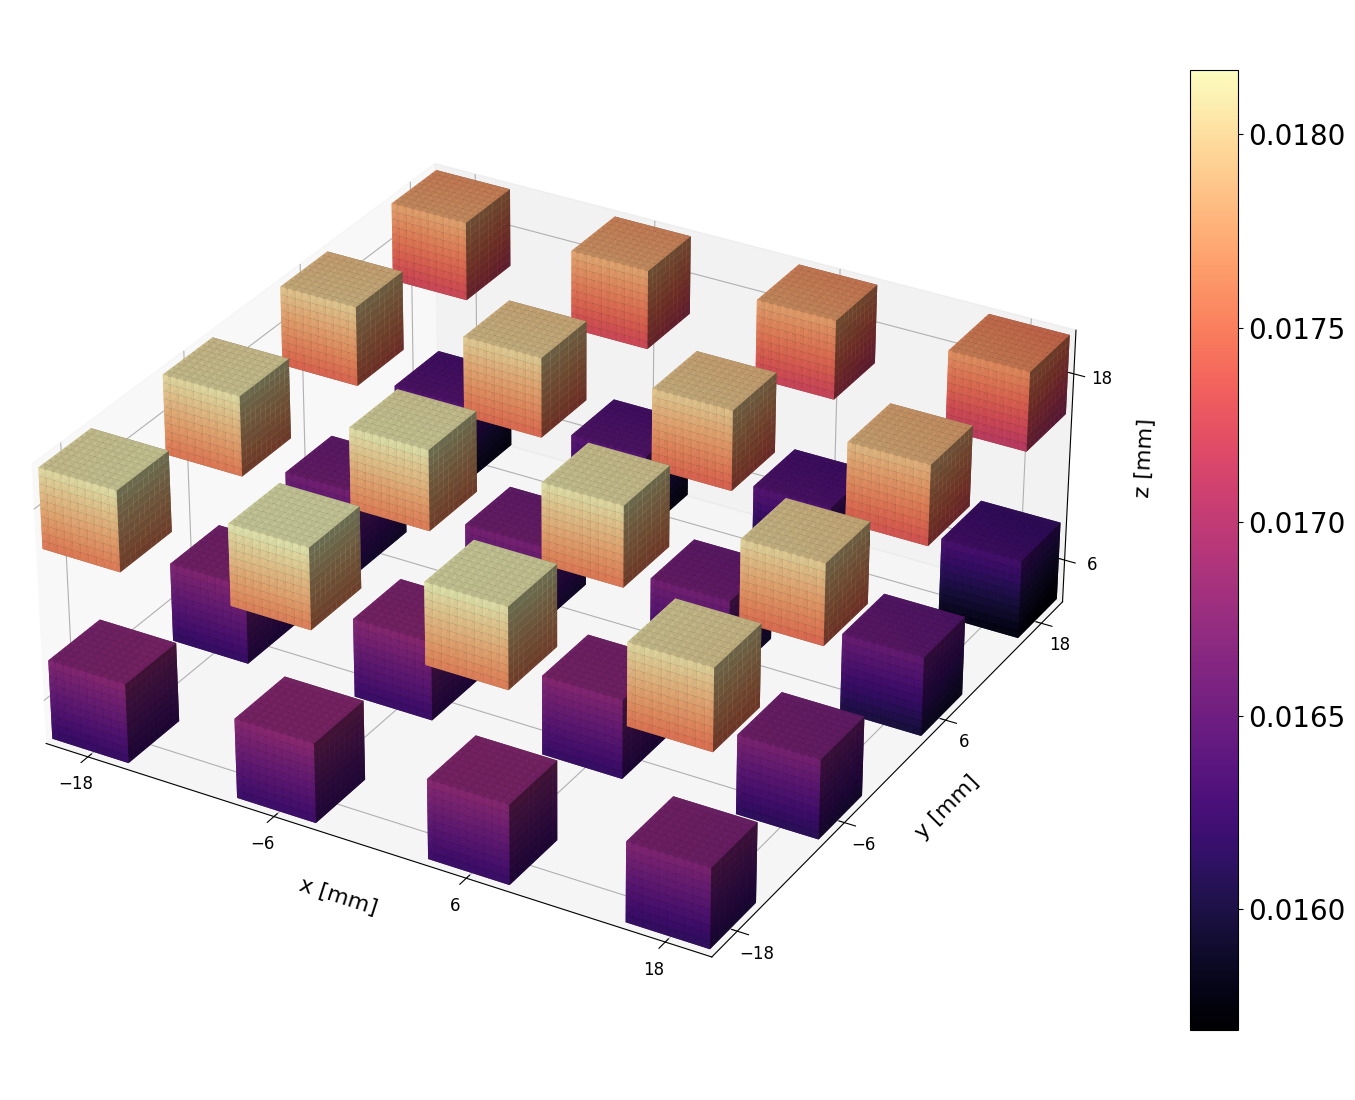

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm
from matplotlib.axes import Axes

phantom_counts_cmap = cm.magma

import matplotlib.pyplot as plt
import numpy as np

from typing import Tuple, Union

## MLC ##

def parse_mlc_data(filename: str) -> Tuple[np.ndarray, np.ndarray, dict[str, Union[float, int]]]:
    with open(filename) as fp:
      data = fp.read()
    lines = data.strip().split('\n')
    
    # read data from comments
    comments = [line for line in lines if line.startswith('#')]
    comment_params = {}
    for comment in comments:
      key = comment.removeprefix("# ").rstrip("0123456789. :")
      value = comment.removeprefix('# ').split(" ", 1)[1]
      if '.' in value:
        try:
          value = float(value)
        except ValueError:
          continue
      else:
        try:
          value = int(value)
        except ValueError:
          continue
      comment_params[key] = value
    
    # remove comments, no longer needed
    lines = [line for line in lines if not line.startswith("#")]
    
    # Parse jaws data
    jaws = np.array(list(map(float, lines[0].split(','))))
    
    # Parse MLC positions
    mlc_positions = []
    for line in lines[1:]:
      if ',' in line:
        left, right = map(float, line.split(','))
        mlc_positions.append((left, right))
    
    return jaws, np.array(mlc_positions), comment_params

## OUTPUT GENERATION ##

def enrich_df(input_df: pd.DataFrame, jaws: np.ndarray, mlc_positions: np.ndarray, target_resolution: int=1, cell_size: int=10) -> pd.DataFrame:
  # otherwise "air" will "stick out" of grid 
  assert (cell_size//target_resolution) % 2 == 0, f"cell_size // target_resolution must be even, but is {cell_size//target_resolution}"

  unique_input_xs = sorted(input_df['X [mm]'].unique())
  unique_input_ys = sorted(input_df['Y [mm]'].unique())
  unique_input_zs = sorted(input_df['Z [mm]'].unique())

  # dla x = -18mm trzeba zrobić w -13.5,-14.5,-15.5,-16.5,-17.5,-18.5,-19.5,-20.5,-21.5,-22.5
  voxel_no_per_cell = int(cell_size//target_resolution)
  total_x_len = len(unique_input_xs) * voxel_no_per_cell
  total_y_len = len(unique_input_ys) * voxel_no_per_cell
  total_z_len = len(unique_input_zs) * voxel_no_per_cell

  patient_cell_material = 0.28947
  air = 0.0211788

  # assuming cube space
  total_space_len = 64 # mm
  space_x_range = (-total_space_len+total_space_len//2, total_space_len-total_space_len//2)
  space_y_range = (-total_space_len+total_space_len//2, total_space_len-total_space_len//2)
  space_z_range = (-total_space_len+total_space_len//2, total_space_len-total_space_len//2)

  print("iterating over input...")
  filled_points = []

  # initial values are out of range, for correct min/max calculation
  min_voxel_x =  total_space_len
  max_voxel_x = -total_space_len
  min_voxel_y =  total_space_len
  max_voxel_y = -total_space_len
  min_voxel_z =  total_space_len
  max_voxel_z = -total_space_len
  
  for _, row in input_df.iterrows():
    # remember parameters from current row
    cell_idx = row["Cell IdX"]
    cell_idy = row["Cell IdY"]
    cell_idz = row["Cell IdZ"]
    dose = row["Dose [Gy]"]

    # generate new coord ranges for voxel entries
    filled_xs = np.linspace(
      row["X [mm]"] - cell_size/2 + target_resolution/2, 
      row["X [mm]"] + cell_size/2 - target_resolution/2, 
      voxel_no_per_cell
    )
    filled_ys = np.linspace(
      row["Y [mm]"] - cell_size/2 + target_resolution/2, 
      row["Y [mm]"] + cell_size/2 - target_resolution/2, 
      voxel_no_per_cell
      )
    filled_zs = np.linspace(
      row["Z [mm]"] - cell_size/2 + target_resolution/2, 
      row["Z [mm]"] + cell_size/2 - target_resolution/2, 
      voxel_no_per_cell
    )
    for voxel_idx, x in enumerate(filled_xs):
      for voxel_idy, y in enumerate(filled_ys):
        for voxel_idz, z in enumerate(filled_zs):
          filled_points.append({
            "x": x, 
            "y": y, 
            "z": z, 
            "cell_idx": int(cell_idx), 
            "cell_idy": int(cell_idy), 
            "cell_idz": int(cell_idz), 
            "voxel_idx": voxel_idx, 
            "voxel_idy": voxel_idy, 
            "voxel_idz": voxel_idz, 
            "dose": dose
          })
          # update voxel ranges
          min_voxel_x = min(min_voxel_x, x)
          max_voxel_x = max(max_voxel_x, x)
          min_voxel_y = min(min_voxel_y, y)
          max_voxel_y = max(max_voxel_y, y)
          min_voxel_z = min(min_voxel_z, z)
          max_voxel_z = max(max_voxel_z, z)
  
  print(f"filling {total_space_len}x{total_space_len}x{total_space_len} space...")
  raw_output = []
  x_iterstart = space_x_range[0] + target_resolution/2
  x_iterend   = space_x_range[1] - target_resolution/2 + 1
  y_iterstart = space_y_range[0] + target_resolution/2
  y_iterend   = space_y_range[1] - target_resolution/2 + 1
  z_iterstart = space_z_range[0] + target_resolution/2
  z_iterend   = space_z_range[1] - target_resolution/2 + 1
  for x in np.arange(x_iterstart, x_iterend, target_resolution):
    print(f"x = {x}")
    for y in np.arange(y_iterstart, y_iterend, target_resolution):
      for z in np.arange(z_iterstart, z_iterend, target_resolution):
        # filter out points outside voxel ranges
        if x < min_voxel_x or x > max_voxel_x or \
           y < min_voxel_y or y > max_voxel_y or \
           z < min_voxel_z or z > max_voxel_z:
          # "air" case
          raw_output.append({
            "Cell IdX": -1,
            "Cell IdY": -1,
            "Cell IdZ": -1,
            "Voxel IdX": -1,
            "Voxel IdY": -1,
            "Voxel IdZ": -1,
            "X [mm]": x,
            "Y [mm]": y,
            "Z [mm]": z,
            "Material": air,
            "Dose": 0,
            "FieldScalingFactor": 0
          })
          continue
        # check if current coords match any entry in filled points
        for index, entry in enumerate(filled_points):
          if x == entry['x'] and y == entry['y'] and z == entry['z']:
            break
        else:
          index = -1
        if index != -1:
          # coords match entry, "detector" case
          raw_output.append({
            "Cell IdX": filled_points[index]["cell_idx"],
            "Cell IdY": filled_points[index]["cell_idy"],
            "Cell IdZ": filled_points[index]["cell_idz"],
            "Voxel IdX": filled_points[index]["voxel_idx"],
            "Voxel IdY": filled_points[index]["voxel_idy"],
            "Voxel IdZ": filled_points[index]["voxel_idz"],
            "X [mm]": x,
            "Y [mm]": y,
            "Z [mm]": z,
            "Material": patient_cell_material,
            "Dose": filled_points[index]["dose"],
            "FieldScalingFactor": calculate_fsf(x, y, z, total_x_len, total_y_len, total_z_len, jaws, mlc_positions)
          })
          # for speedup, delete for multiprocessing code
          del filled_points[index]
        else:
          # coords do not match entry, "air" case
          raw_output.append({
            "Cell IdX": -1,
            "Cell IdY": -1,
            "Cell IdZ": -1,
            "Voxel IdX": -1,
            "Voxel IdY": -1,
            "Voxel IdZ": -1,
            "X [mm]": x,
            "Y [mm]": y,
            "Z [mm]": z,
            "Material": air,
            "Dose": 0,
            "FieldScalingFactor": 0
          })
  return pd.DataFrame(raw_output)

## FSF ##

def calculate_fsf(x: np.float64, y: np.float64, z: np.float64, nx: int, ny: int, nz: int, jaws: np.ndarray, mlc_positions: np.ndarray) -> np.float64:
  """
  Assumptions: 
  - MLC_leaf positions are calculated as (x_leaf, y_leaf+leaf_height/2, mlc_detector_distance) V
  - angles are calculated in radians (0, np.pi)
  - closed jaws are skipped V
  - y1MLC == y2MLC (???) ?
  - detector_distance is positive V
  """
  *_, Y1, Y2 = jaws
  n_leaves = len(mlc_positions)
  leaf_height = (Y2 - Y1) / n_leaves
  mlc_detector_distance = 340
  mlc_centre = np.array((0, 0, mlc_detector_distance))

  y1MLC = 0
  y2MLC = 0

  current_y = Y1 + leaf_height/2
  for x_left, x_right in mlc_positions:
    if x_left == x_right: # skip closed leafs
      continue
    r_mlc = mlc_centre - np.array((x, y, z))

    r_leaf_left = (mlc_centre + np.array((x_left, current_y, 0))) - np.array((x, y, z))
    r_leaf_right= (mlc_centre + np.array((x_right, current_y, 0))) - np.array((x, y, z))

    lambda_leaf_left = angle_between(r_mlc, r_leaf_left)
    lambda_leaf_right = angle_between(r_mlc, r_leaf_right)

    y1MLC += lambda_leaf_left + lambda_leaf_right
    y2MLC += lambda_leaf_left + lambda_leaf_right

    current_y += leaf_height
  fsf = y1MLC + y2MLC
  # nx = 4
  # ny = 4
  # nz = 2
  fsf_norm = fsf/(1*nx + 2*ny + 3*nz)
  min_scaling = 0.02
  max_scaling = 0.98
  fsf_minmax_norm = (fsf_norm - min_scaling)/(max_scaling - min_scaling)
  return fsf_minmax_norm

def angle_between(v1: np.ndarray, v2: np.ndarray) -> np.float64:
  """ Returns the angle in radians between vectors v1 and v2"""
  v1_len = np.sqrt(v1[0]**2 + v1[1]**2 + v1[2]**2)
  v2_len = np.sqrt(v2[0]**2 + v2[1]**2 + v2[2]**2)
  return np.arccos(np.dot(v1, v2)/(v1_len*v2_len))

## PLOTTING ##

def add_voxel(ax, x_center: float, y_center: float, z_center: float, voxel_side_len: float, dose: float, min: float, max: float) -> None:
  x = [x_center - voxel_side_len / 2, x_center + voxel_side_len / 2]
  y = [y_center - voxel_side_len / 2, y_center + voxel_side_len / 2]
  z = [z_center - voxel_side_len / 2, z_center + voxel_side_len / 2]
  # print(f"voxel bounds, x: {x}, y: {y}, z: {z}")
  xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')
  
  phantom_counts_norm = colors.Normalize(vmin=min, vmax=max)
  pc_normalized = phantom_counts_norm(dose)
  pc_colored = np.empty((*pc_normalized.shape, 4))
  with np.nditer(pc_normalized, flags=['multi_index']) as it:
    for el in it:
      pc_colored[it.multi_index] = phantom_counts_cmap(el, alpha=(0.9))
  ax.voxels(xx, yy, zz, np.ones((1,1,1), dtype=bool), facecolors=pc_colored, edgecolor=None)

def plot_df(df: pd.DataFrame, ticks_x: np.ndarray, ticks_y: np.ndarray, ticks_z: np.ndarray, target_resolution: int) -> None:
  observable = "FieldScalingFactor"

  fig = plt.figure(figsize=(16, 12))
  ax = fig.add_subplot(111, projection='3d')

  df_nonzero_observable = df[df[observable] > 0]

  dose_max = df[observable].max()
  dose_min = df_nonzero_observable[observable].min()

  counter=1
  max_voxel=len(df_nonzero_observable)

  # max_iter = 10
  # iter_counter = 0
  for _, row in df_nonzero_observable.iterrows():
    # if iter_counter > max_iter:
    #   break
    # else:
    #   iter_counter+=1
    if row[observable] == 0:
      # skip air
      continue
    x_center = row['X [mm]']
    y_center = row['Y [mm]']
    z_center = row['Z [mm]']

    dose = row[observable]
    print(f"adding {counter}/{max_voxel} voxel...")
    # print(f"center in {x_center},{y_center},{z_center}")
    counter+=1

    add_voxel(ax, x_center, y_center, z_center, target_resolution, dose, dose_min, dose_max)
  
  print("rendering image...")
  # Ustawienie limitów osi
  x_min, x_max = df_nonzero_observable['X [mm]'].min() - target_resolution, df_nonzero_observable['X [mm]'].max() + target_resolution
  y_min, y_max = df_nonzero_observable['Y [mm]'].min() - target_resolution, df_nonzero_observable['Y [mm]'].max() + target_resolution
  z_min, z_max = df_nonzero_observable['Z [mm]'].min() - target_resolution, df_nonzero_observable['Z [mm]'].max() + target_resolution

  ax.set_xlim([x_min, x_max])
  ax.set_ylim([y_min, y_max])
  ax.set_zlim([z_min, z_max])

  x_scale = x_max - x_min
  y_scale = y_max - y_min
  z_scale = z_max - z_min
  ax.set_box_aspect([1.2*x_scale, 1.2*y_scale, 1.2*z_scale])
  ax.set_xlabel("x [mm]", fontsize=16,labelpad=10)
  ax.set_ylabel("y [mm]", fontsize=16,labelpad=10)
  ax.set_zlabel("z [mm]", fontsize=16,labelpad=10)
  ax.set_xticks(ticks_x)
  ax.set_yticks(ticks_y)
  ax.set_zticks(ticks_z)
  ax.tick_params(labelsize=12)
  plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
  scalar_mappable = cm.ScalarMappable(norm=colors.Normalize(vmin=dose_min, vmax=dose_max), cmap=phantom_counts_cmap)
  colorbar_axes = fig.add_axes([0.9, 0.1, 0.03, 0.8])  # Adjust the position as needed
  cbar = fig.colorbar(scalar_mappable, cax=colorbar_axes, shrink=1.0, fraction=0.1, pad=0)
  cbar.ax.tick_params(labelsize=20)
  plt.show()

if __name__ == "__main__":
  target_resolution = 1 # mm
  cell_size = 10 #mm

  data_filename = "cp-0_d3ddetector_cell.csv"
  raw_df = pd.read_csv(data_filename)

  mlc_filename = "1. prostate_imrt_beam0_cp0.dat"
  jaws, mlc_positions, _ = parse_mlc_data(mlc_filename)
  unique_xs_raw = np.array(sorted(raw_df['X [mm]'].unique()))
  unique_ys_raw = np.array(sorted(raw_df['Y [mm]'].unique()))
  unique_zs_raw = np.array(sorted(raw_df['Z [mm]'].unique()))

  sorted_df = raw_df.sort_values(by=['X [mm]', 'Y [mm]', 'Z [mm]'])
  df = enrich_df(sorted_df, jaws, mlc_positions, target_resolution, cell_size)

  df.to_csv("output.csv", index=False)
  plot_df(df, unique_xs_raw, unique_ys_raw, unique_zs_raw, target_resolution)


# TODO sześcianik ma długość 10mm, hardcoded ale do sterowania w przyszłości              WiP
# TODO układ jak w slajdzie, wzrost z w szecianach to schodzenie wgłąb fantoma            not yet
# TODO iteruj się najpierw po y, potem powiedzmy po x i z, ale to już ma małe znaczenie   ✓?
# TODO FSF do zmiany                                                                      not yet
# TODO Indeksacja do zmiany                                                               check
# TODO: parallelizing with numba??                                                        not yet
# TODO: sprawdź czy zmiana gridu z 64x64x64 na inny wywala program (powinna?)             not yet